# General setting

In all of the following graphs we use the transition probabilites estimated from group 4 of John Rust's 1987 paper. We stylize the cost parameters to (10, 10), instead if (10, 2.27). The simulation exercises are always with 200 buses over 70000 periods. For the construction of the uncertainty sets we always use the mean number of observations 4292 / 388.

In [1]:
extract_zips()

# Worst case probabilities

Shift of worst case probabilities for varying $\omega$ in state 150. But first a single plot of the ML estimate.

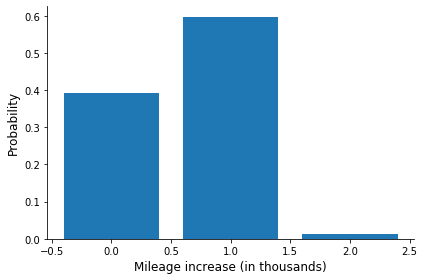

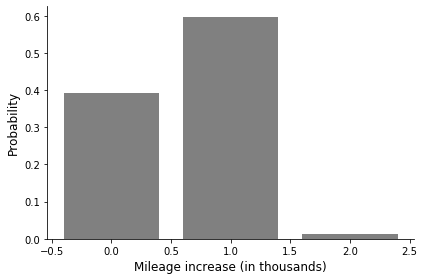

In [2]:
get_probabilities()

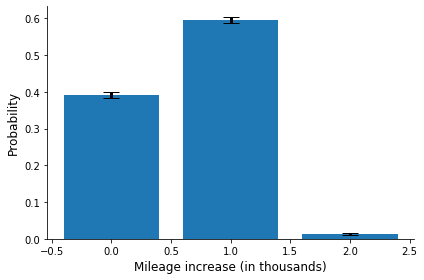

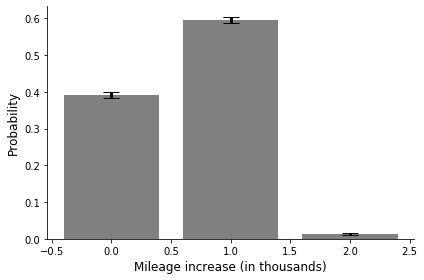

In [3]:
get_probabilities_bar()

In [4]:
df_probability_shift()

,0,4292_0.50,4292_0.95
0,0.391892,0.316635,0.239579
1,0.595294,0.665553,0.735074
2,0.012815,0.017811,0.025347
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000


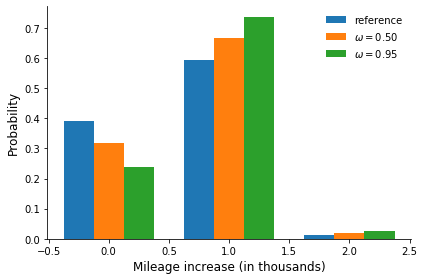

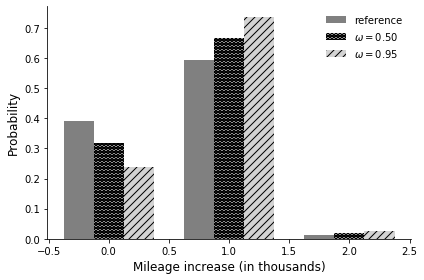

In [6]:
get_probability_shift()

In [7]:
# get_probability_shift_data()

# Replacement/Maintenance probability curve

The following figure shows the shift of the replacement probability curve. 

In [8]:
df_maintenance_probabilties()

,0.00,0.50,0.95
0,0.999955,0.999955,0.999955
1,0.999944,0.999944,0.999944
2,0.999930,0.999931,0.999931
3,0.999914,0.999915,0.999915
4,0.999894,0.999895,0.999895
...,...,...,...
395,0.037059,0.037371,0.037485
396,0.036696,0.037005,0.037117
397,0.036339,0.036646,0.036757
398,0.035989,0.036293,0.036403


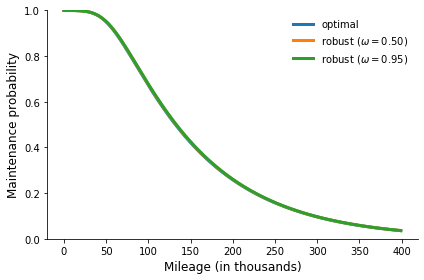

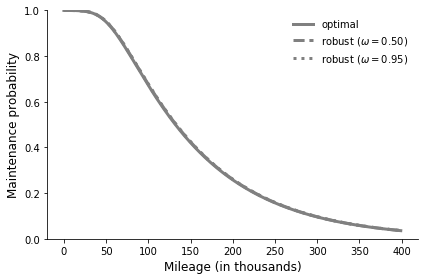

In [9]:
get_maintenance_probabilities()

In [10]:
df_replacement_probabilties()

,0.00,0.50,0.95
0,0.000045,0.000045,0.000045
1,0.000056,0.000056,0.000056
2,0.000070,0.000069,0.000069
3,0.000086,0.000085,0.000085
4,0.000106,0.000105,0.000105
...,...,...,...
395,0.962941,0.962629,0.962515
396,0.963304,0.962995,0.962883
397,0.963661,0.963354,0.963243
398,0.964011,0.963707,0.963597


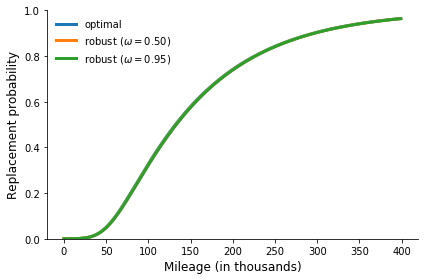

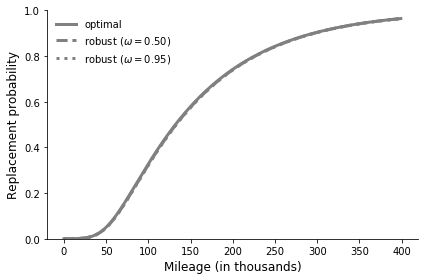

In [11]:
get_replacement_probabilities()

# Threshold plot

## Should we vary training sample and show effect? This is useful to discuss / explore the link between $\omega$ and the other paramters. This should be done in any case, the question is where.

The following figure shows the average state of replacement observed in simulated data. The means are rounded due to standard rounding rules. The underlying transition matrix governing the stochastic process of the milage increase is the ML estimate of Rust's paper.


In [12]:
df_thresholds()

,omega,threshold
0,0.00,67
1,0.01,72
2,0.02,73
3,0.03,73
4,0.04,73
...,...,...
95,0.95,80
96,0.96,80
97,0.97,80
98,0.98,81


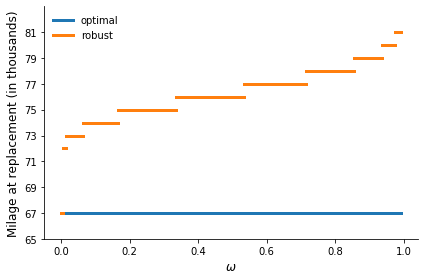

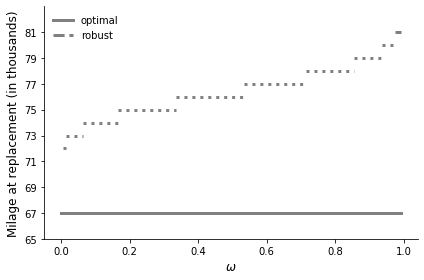

In [13]:
get_replacement_thresholds()

# Performance of 

The following figure shows the performance of the nominal strategy, when the worst case transition matrix of ω=0.95 is underlying. The two benchmarks are the expected value of an optimal strategy, when the underlying transition matrix is the ML estimate or the worst case transition matrix for omega=0.95.

In [14]:
get_decision_rule_df()

,period,disc_strategy,exp_value
0,0,0.000000,-6548.662581
1,1000,-839.221363,-6548.662581
2,2000,-1607.227298,-6548.662581
3,3000,-2306.587881,-6548.662581
4,4000,-2934.671016,-6548.662581
...,...,...,...
66,66000,-8916.219915,-6548.662581
67,67000,-8917.380517,-6548.662581
68,68000,-8918.429944,-6548.662581
69,69000,-8919.376547,-6548.662581


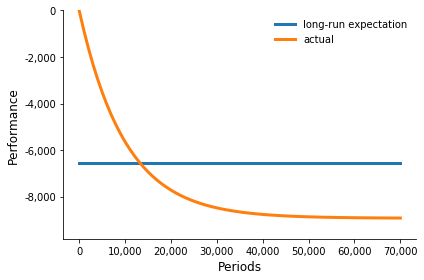

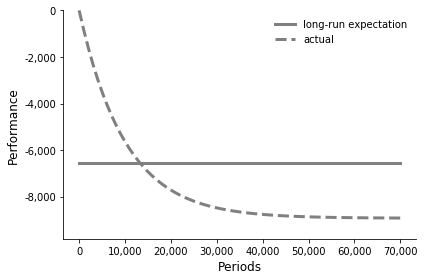

In [15]:
get_performance_decision_rules()

# Performance plot

The following figure show the simulated value at time zero of different strategies given the worst case transition matrix according to the $\omega$ on the x-axis.

In [16]:
df = get_difference_df()

The dataframe contains the difference for robust - nominal strategy.


In [17]:
df[df["omega"] == 0.50]

,omega,robust_95,robust_050
50,0.5,60.036519,69.12453


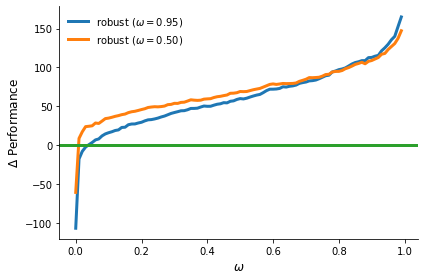

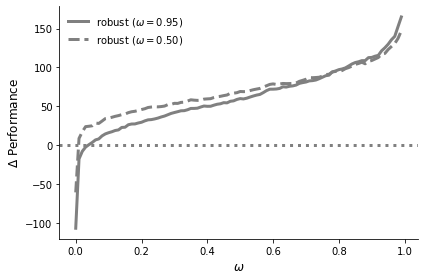

In [18]:
get_difference_plot()

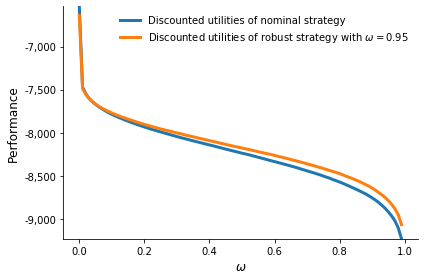

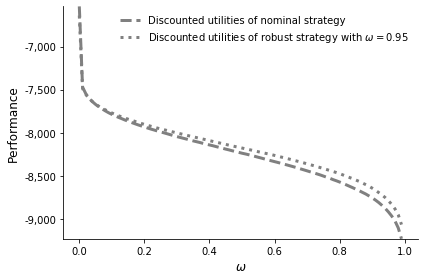

In [19]:
get_performance()

# Out of sample performance

In [23]:
# 'get_out_of_sample_2223_05()'

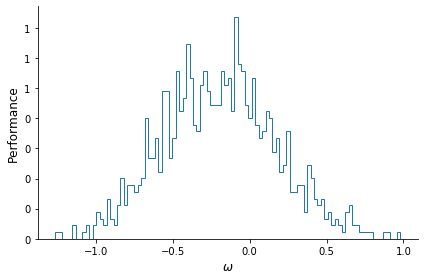

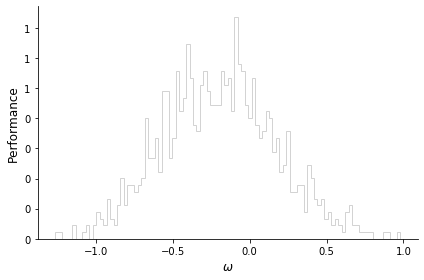

In [28]:
get_out_of_sample_4292_05()